Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)


# Imports & Setting up directories

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:  
    PATH = './' # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/1_SP_Ham_func/furuta_pendulum/
    %pip install torchdiffeq
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *
else:
    import sys; sys.path.insert(0, '..') 
    import os
    PATH = '../'
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torch.optim.lr_scheduler import LinearLR

from torchdiffeq import odeint_adjoint as odeint_adjoint 
# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time
import json

# setting seeds

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training

#### simple_HNN 

##### 10k parameters - w horizon - with rescaling 

In [31]:
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
gtype = None  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800
num_trajectories = 125
proportion = 0.8
batch_size = 100
w_rescale = [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False
coord_type = 'hamiltonian'
rescale_dims = [1, 1, 1, 0]
min_max_rescale = False

### Parameters for the training procedure
resnet_config = None # 
alternating = False # for Input_HNN, if G is a neural network, train 
horizon_type = 'auto' # 'auto' or 'constant'
horizon = False # if horizon_type == 'constant', use this horizon
loss_type = 'L2' # 'L2' or 'L2weighted' 
collect_grads = False # collect gradients in all layers at every epoch
rescale_loss = False # rescale the difference between nominal and train by the min max of train trajectory in loss function
grad_clip = False  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)

cpu


In [32]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [33]:
# initialise the model that will be trianed
model_name = 'simple_HNN'
H_net = MLP(input_dim=4, hidden_dim=70, nb_hidden_layers=2,
            output_dim=1, activation='x+sin(x)^2')  # load H model
model = simple_HNN(input_dim=4, H_net=H_net,
                   device=device)  # load neural ODE model
model.to(device)  # send model to devie ( cpu or gpu )

# create file name from parameters
num_params = count_parameters(model)

save_prefix = name_from_params(Ts, rescale_loss, weights, epoch_number, num_params, utype, model_name,
                               num_trajectories, furuta_type, noise_std,
                               grad_clip, lr_schedule, C_q1, C_q2, horizon, min_max_rescale)
                               
# print some information on the training and file name
print('Total number of epochs:', epoch_number)
print('H_net number of parameters :', num_params)
print('Save file prefix : ', save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

Total number of epochs: 700
H_net number of parameters : 10363
Save file prefix :  simple_HNN_noinput_125traj_real_noise0.0_700e_p10k_Ts0.005_nodissip_
horizon_list and switch_steps have the same size


In [34]:
# set all paths and create folders : 
model_path = PATH+'data/'+save_prefix+'/'
stats_path = PATH+'data/'+save_prefix+'/'
plot_path = PATH+'data/'+save_prefix+'/img/'
train_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
test_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [35]:
torch.save(train_loader, train_loader_path + 'train_loader.pt')
if test_loader is not None:
    torch.save(test_loader, test_loader_path + 'test_loader.pt')

# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)

horizon length : 50


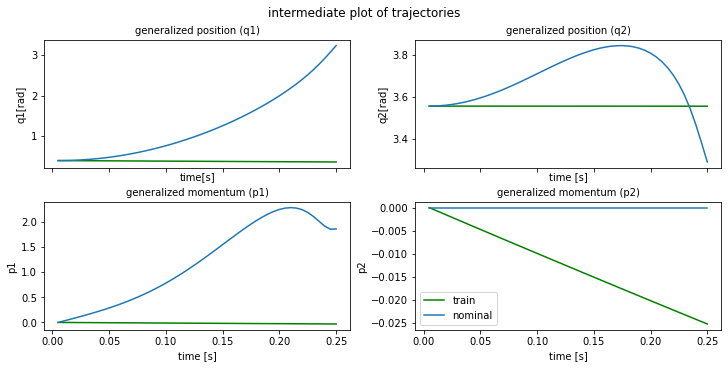

plot time : 0.9104907512664795
epoch    0 | train time 1.91 | train loss 4.311710e+00 | test loss 4.147029e+00 | test time 0.26  
epoch    1 | train time 1.03 | train loss 4.262741e+00 
epoch    2 | train time 0.85 | train loss 4.216961e+00 
epoch    3 | train time 0.81 | train loss 4.172857e+00 
epoch    4 | train time 0.77 | train loss 4.128954e+00 
epoch    5 | train time 0.85 | train loss 4.083947e+00 
epoch    6 | train time 0.92 | train loss 4.036723e+00 
epoch    7 | train time 1.12 | train loss 3.986251e+00 
epoch    8 | train time 1.10 | train loss 3.931514e+00 
epoch    9 | train time 0.81 | train loss 3.871504e+00 


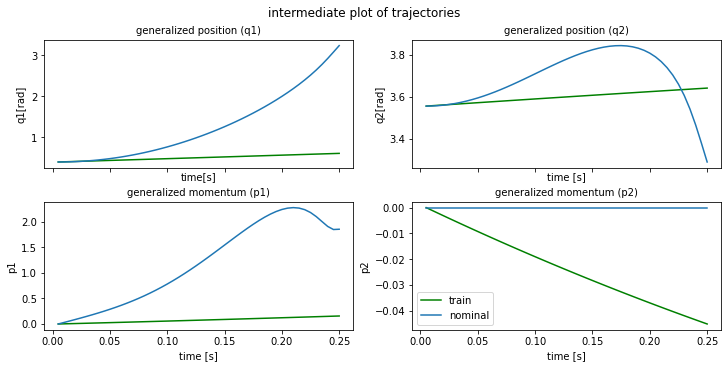

plot time : 0.6626198291778564
epoch   10 | train time 1.62 | train loss 3.805291e+00 | test loss 3.736340e+00 | test time 0.26  
epoch   11 | train time 0.87 | train loss 3.732134e+00 
epoch   12 | train time 0.76 | train loss 3.651572e+00 
epoch   13 | train time 0.82 | train loss 3.563479e+00 
epoch   14 | train time 0.89 | train loss 3.468030e+00 
epoch   15 | train time 0.75 | train loss 3.365528e+00 
epoch   16 | train time 0.88 | train loss 3.256275e+00 
epoch   17 | train time 0.77 | train loss 3.140517e+00 
epoch   18 | train time 0.91 | train loss 3.018518e+00 
epoch   19 | train time 0.94 | train loss 2.890735e+00 


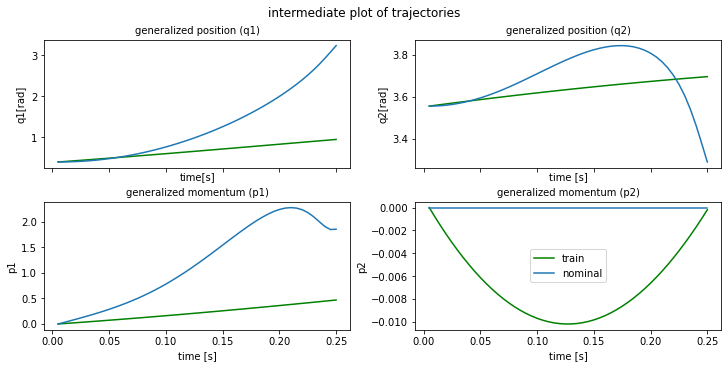

plot time : 0.6806089878082275
epoch   20 | train time 1.65 | train loss 2.757892e+00 | test loss 2.801037e+00 | test time 0.31  
epoch   21 | train time 0.92 | train loss 2.620938e+00 
epoch   22 | train time 0.89 | train loss 2.480891e+00 
epoch   23 | train time 1.14 | train loss 2.338708e+00 
epoch   24 | train time 0.90 | train loss 2.195344e+00 


In [36]:
stats = train(device = device, model = model, 
            Ts = Ts, 
            train_loader = train_loader, 
            test_loader = test_loader, 
            w=torch.tensor(weights, device=device),
            grad_clip = grad_clip,
            lr_schedule = lr_schedule,
            begin_decay = begin_decay, 
            resnet_config = resnet_config,
            epoch_number = epoch_number, 
            alternating = alternating,
            horizon = horizon, 
            horizon_type = horizon_type, 
            horizon_list = horizon_list, 
            switch_steps = switch_steps, 
            epochs = epoch_number, 
            loss_type = loss_type, 
            collect_grads = collect_grads,
            rescale_loss = rescale_loss,
            rescale_dims = rescale_dims
            )

In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# save model to disk
torch.save(model.state_dict(), model_path+'model')

# save the stats
save_stats(stats, stats_path+'stats.txt')

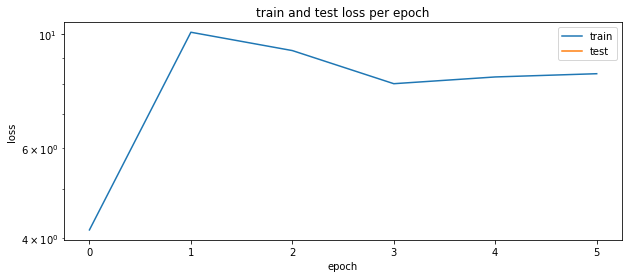

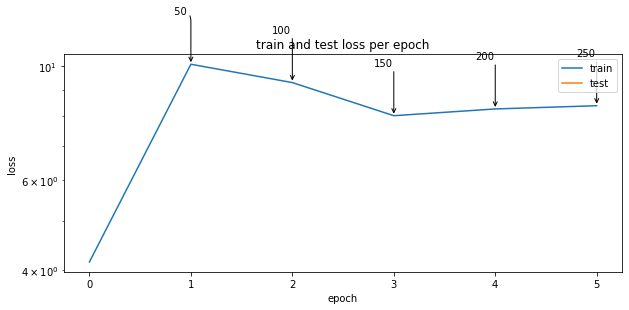

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test.png',
                     title='train and test loss per epoch', horizons=False, switch_steps=switch_steps)

train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test_warrows.png',
                     title='train and test loss per epoch', horizons=horizon_list[:-1], switch_steps=switch_steps)


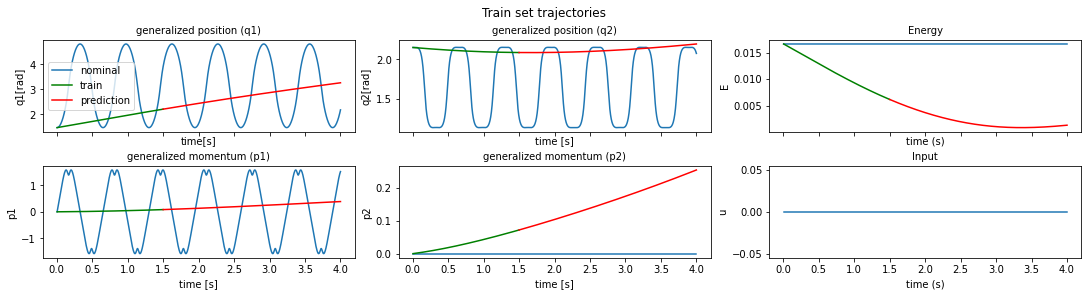

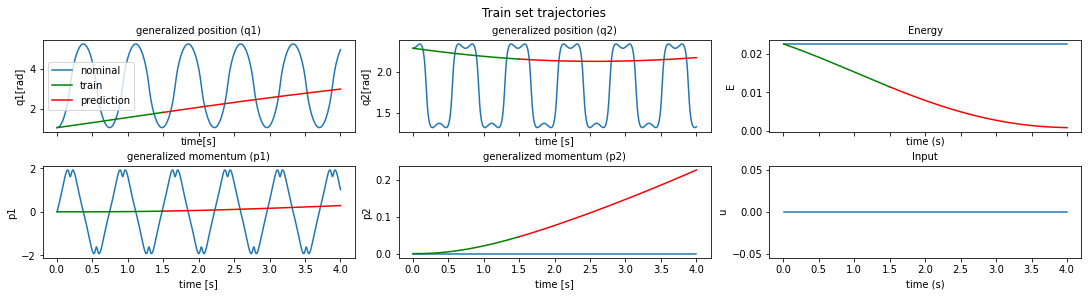

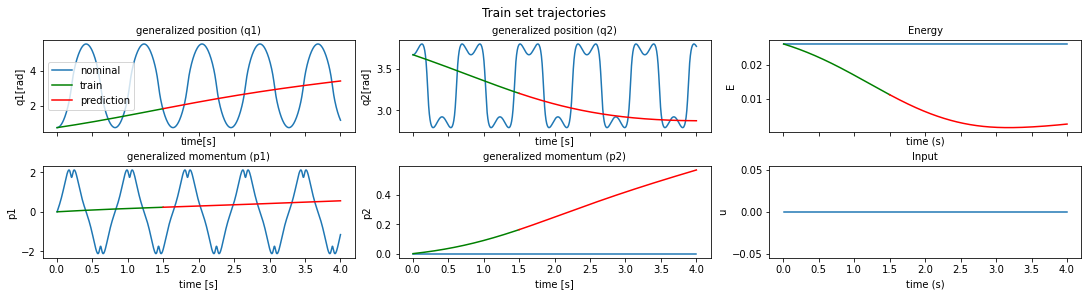

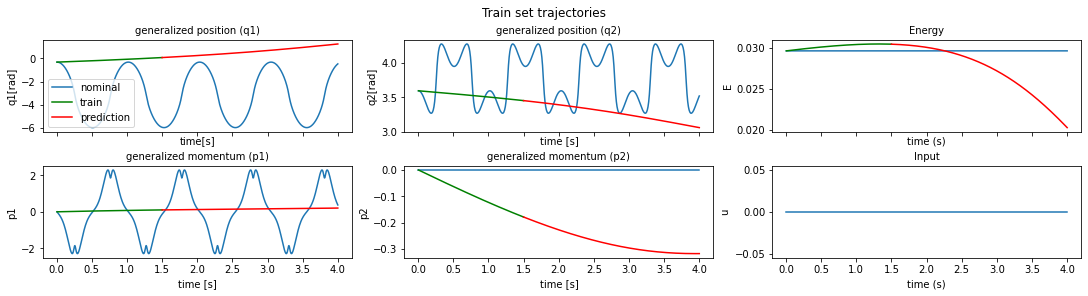

In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


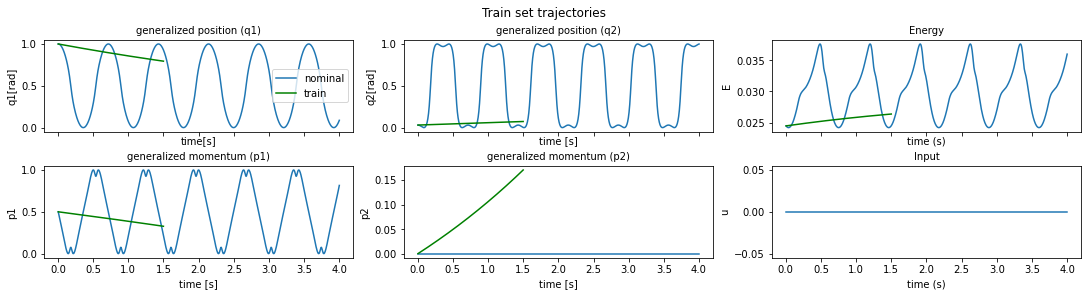

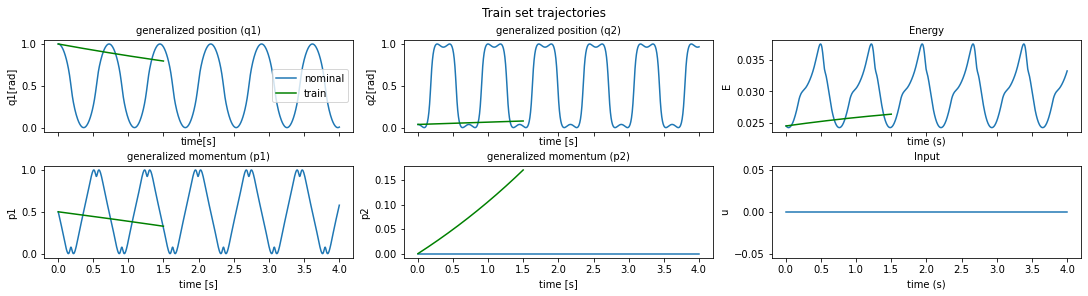

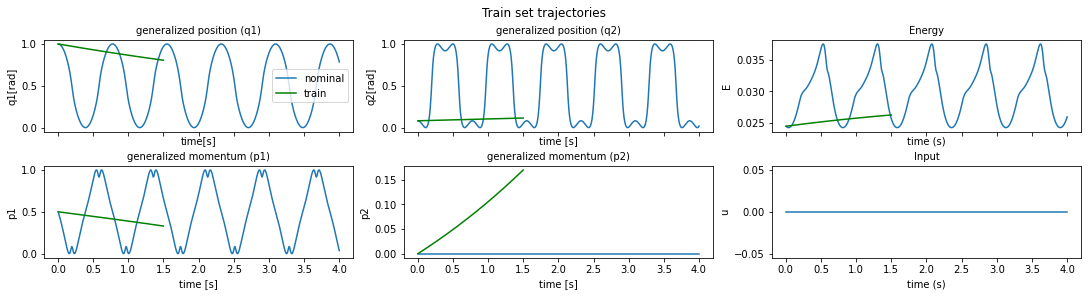

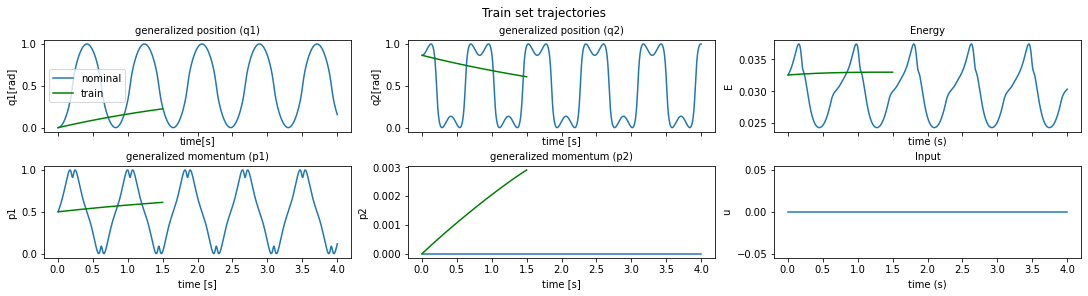

In [ ]:
# show only training portion
for n in [0, 50, 70, 80]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=horizon_list[-1],
                        n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, t_plot=horizon_list[-1], show_pred=False,
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


##### 10k parameters - w horizon - with rescaling - with grad clipping

In [ ]:
device = set_device()  # set it to gpu if it is available

### Parameters to generate the dataset
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
gtype = None  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800
num_trajectories = 125
proportion = 0.8
batch_size = 100
w_rescale = [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False
coord_type = 'hamiltonian'
rescale_dims = [1, 1, 1, 0]
min_max_rescale = True

### Parameters for the training procedure
resnet_config = None
alternating = False
horizon = False
horizon_type = 'auto'
loss_type = 'L2'
collect_grads = False
rescale_loss = True
grad_clip = True  # activate gradient clipping
lr_schedule = True  # activate lr schedule
begin_decay = 2250  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)

In [ ]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [ ]:
# initialise the model that will be trianed
model_name = 'simple_HNN'
H_net = MLP(input_dim=4, hidden_dim=70, nb_hidden_layers=2,
            output_dim=1, activation='x+sin(x)^2')  # load H model
model = simple_HNN(input_dim=4, H_net=H_net,
                   device=device)  # load neural ODE model
model.to(device)  # send model to devie ( cpu or gpu )

# create file name from parameters
num_params = count_parameters(model)
weights_title = ' | weights = ' + str(weights)
save_prefix = '{:d}e_p{:d}k_Ts{:1.3f}_'.format(
    epoch_number, int((num_params-num_params % 1000)/1000), Ts)
if utype is None:
    input = 'noinput'
else:
    input = utype
save_prefix = model_name + '_' + input + '_' + \
    str(num_trajectories)+'traj'+'_' + furuta_type + \
    '_' + 'noise'+str(noise_std)+'_' + save_prefix
if grad_clip:
    save_prefix = save_prefix + 'gradcl_'
if lr_schedule:
    save_prefix = save_prefix + 'lrsched_'
if C_q1 == 0 and C_q2 == 0:
    save_prefix = save_prefix + 'nodissip_'
else:
    save_prefix = save_prefix + 'wdissip_'
if horizon:
    save_prefix = save_prefix + 'constanthorizon_'
if rescale_loss:
    save_prefix = save_prefix + 'rescaledloss_'
if min_max_rescale:
    save_prefix = save_prefix + 'trajminmaxrescale_'

# print some information on the training and file name
print('Total number of epochs:', epoch_number)
print('H_net number of parameters :', num_params)
print('Save file prefix : ', save_prefix)

# Sanity check
if len(horizon_list) == len(switch_steps):
    print('horizon_list and switch_steps have the same size')
else:
    raise ValueError('horizon_list and switch_steps do NOT have the same size')


In [ ]:
stats = train(device = device, model = model, 
            Ts = Ts, 
            train_loader = train_loader, 
            test_loader = test_loader, 
            w=torch.tensor(weights, device=device),
            grad_clip = grad_clip,
            lr_schedule = lr_schedule,
            begin_decay = begin_decay, 
            resnet_config = resnet_config,
            epoch_number = epoch_number, 
            alternating = alternating,
            horizon = horizon, 
            horizon_type = horizon_type, 
            horizon_list = horizon_list, 
            switch_steps = switch_steps, 
            epochs = epoch_number, 
            loss_type = loss_type, 
            collect_grads = collect_grads,
            rescale_loss = rescale_loss,
            rescale_dims = rescale_dims
            )

In [ ]:
# save model to disk
model_path = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_path)

# save the stats
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'
save_stats(stats, stats_path)

In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'data/img/'+save_prefix+'LOSS_train_test.png', 
                     title='train and test loss per epoch', horizons = False )

train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'data/img/'+save_prefix+'LOSS_train_test_warrows.png', 
                     title='train and test loss per epoch', horizons = horizon_list[:-1], horizon_steps = horizon_steps )

In [ ]:
# show train and prediction

for n in [0,5,10,19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, 
                        t_max=200, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=300, show_pred=True, H_or_Input = 'input',
                        title = 'Train set trajectories', file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'_nopred.png')

In [ ]:
# show only training portion
for n in [0,50,70,80]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=300, 
    n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, t_plot=300, show_pred=False,
    title = 'Train set trajectories', file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'.png')

##### 30k parameters - no rescaling

##### 30k parameters - w horizon - with rescaling

##### 30k parameters - w horizon - with rescaling - with grad clipping

#### NESHDNN + mlp + input

In [ ]:
device = set_device()
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
# C_q1, C_q2 = 0.000009, 0.00004
utype = 'chirp'  # 'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800
num_trajectories = 100
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 100000]  # [1, 9000, 1, 10000]
coord_type = 'hamiltonian'
min_max_rescale = True
rescale_dims = [1, 1, 1, 1]
shuffle = False
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims = rescale_dims)


In [ ]:
# horizon_list = [40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]
# switch_steps = [500, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [300, 200, 200, 100, 100, 100]
epoch_number = sum(switch_steps)
grad_clip = True  # activate gradient clipping
lr_schedule = True  # activate lr schedule
begin_decay = 2250  # epoch at which lr starts decaying

model_name = 'NESHDNN_mlp'

H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4,
            output_dim=1, activation='x+sin(x)^2')
model = Nes_HDNN(u_func=u_func, G_net=g_func,
                 H_net=H_net, device=device, dissip=False)
model.to(device)
num_params = count_parameters(model)

weights = [1.0, 1.0, 1.0, 1.0]
weights_title = ' | weights = ' + str(weights)

save_prefix = '{:d}e_w{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_Ts{:1.3f}_'.format(
    epoch_number, weights[0], weights[1], weights[2], weights[3], int((num_params-num_params % 1000)/1000), Ts)
if utype is None:
    input = 'noinput'
else:
    input = utype
save_prefix = model_name + '_' + input + '_' + \
    str(num_trajectories)+'traj'+'_' + furuta_type + \
    '_' + 'noise'+str(noise_std)+'_' + save_prefix
if grad_clip:
    save_prefix = save_prefix + 'gradcl_'
if lr_schedule:
    save_prefix = save_prefix + 'lrsched_'
if C_q1 == 0 and C_q2 == 0:
    save_prefix = save_prefix + 'nodissip'
else:
    save_prefix = save_prefix + 'wdissip'

print('Total number of epochs:', epoch_number)
print('H_net number of parameters :', num_params)
print('Save file prefix : ', save_prefix)

if len(horizon_list) == len(switch_steps):
    print('horizon_list and switch_steps have the same size ')
else:
    raise ValueError('horizon_list and switch_steps do NOT have the same size ', len(
        horizon_list), len(switch_steps))

In [ ]:
stats = train(model=model,
              Ts=Ts,
              train_loader=train_loader,
              test_loader=test_loader,
              w=torch.tensor(weights, device=device),
              grad_clip=grad_clip,
              lr_schedule=lr_schedule,
              begin_decay=begin_decay,
              resnet_config=None,
              epoch_number=epoch_number,
              alternating=False,
              horizon=False,
              horizon_type='auto',
              horizon_list=horizon_list,
              switch_steps=switch_steps,
              epochs=epoch_number,
              loss_type='L2',
              collect_grads=False,
              rescale_loss=True,
              rescale_dims=[1, 1, 1, 1])

In [ ]:
# save model to disk
model_path = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_path)

# save the stats
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'
save_stats(stats, stats_path)

#### Resnet config 1

In [ ]:
device = set_device()
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
# C_q1, C_q2 = 0.000009, 0.00004
utype = 'sine'  # 'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 5  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi'  # 'random_nozero' # 'random_closetopi'
time_steps = 800
num_trajectories = 1
proportion = 0.0
batch_size = 100
w_rescale = [1, 10000, 1, 100000]  # [1, 9000, 1, 10000] # [1,1,1,1]#
coord_type = 'hamiltonian'
min_max_rescale = False
rescale_dims = [1, 1, 1, 1]
shuffle = False
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims = rescale_dims)


In [ ]:
# horizon_list = [20,40,60]
# switch_steps = [200,200,200]
horizon_list = [50,100,150]
switch_steps = [300,300,300]
epoch_number = sum(switch_steps)
grad_clip = True # activate gradient clipping
lr_schedule = False # activate lr schedule
begin_decay = 2250 # epoch at which lr starts decaying

model_name = 'NESHDNN_resnet_conf1'

H_net = ResNet_config1(resblock_list=[0], num_blocks = 6, input_dim=4, hidden_dim=40, 
                nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)

model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device, dissip=False)
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1

weights = [1.0, 1.0, 1.0, 1.0] 
weights_title = ' | weights = ' + str(weights)

save_prefix = '{:d}e_w{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_Ts{:1.3f}_'.format(epoch_number,weights[0],weights[1],weights[2],weights[3],int((num_params-num_params%1000)/1000),Ts)
if utype is None:
    input = 'noinput'
else :
    input = utype
save_prefix = model_name +'_'+ input + '_' + str(num_trajectories)+'traj'+'_' + furuta_type + '_' + 'noise'+str(noise_std)+'_'+  save_prefix 
if grad_clip:
    save_prefix = save_prefix + 'gradcl_'
if lr_schedule: 
    save_prefix = save_prefix + 'lrsched_'
if C_q1==0 and C_q2==0:
    save_prefix = save_prefix + 'nodissip'
else:
    save_prefix = save_prefix + 'wdissip'

print('Total number of epochs:', epoch_number)
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of H_net parameters :', num_params)
print('Save file prefix : ', save_prefix)

if len(horizon_list) == len(switch_steps) :
    print('horizon_list and switch_steps have the same size ')
else:
    raise ValueError('horizon_list and switch_steps do NOT have the same size ',len(horizon_list),len(switch_steps))

In [ ]:
model.H_net.resblock_list

In [ ]:
stats = train(model=model,
            Ts=Ts,
            train_loader=train_loader,
            test_loader=test_loader,
            w=torch.tensor(weights, device=device),
            grad_clip=grad_clip,
            lr_schedule=lr_schedule,
            begin_decay=begin_decay,
            resnet_config=1,
            epoch_number=epoch_number,
            alternating=False,
            horizon=False,
            horizon_type='auto',
            horizon_list=horizon_list,
            switch_steps=switch_steps,
            epochs=epoch_number,
            loss_type='L2weighted',
            collect_grads=False,
            rescale_loss = True,
            rescale_dims = [1, 1, 1, 1])


In [ ]:
# save model to disk
model_path = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_path)

# save the stats
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'
save_stats(stats, stats_path)

#### Resnet config 2

In [ ]:
device = set_device()
furuta_type = 'real' # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) 

utype = 'chirp' #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 4 # 4 # 1.4
u_func.params['scale'] = 0.001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype='simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero' # 'random_nozero' # 'random_closetopi'
time_steps= 800
num_trajectories = 1
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 10000] # [1, 9000, 1, 10000]
coord_type = 'hamiltonian'
min_max_rescale = False
rescale_dims = [1, 1, 1, 1]
shuffle = False
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims = rescale_dims)

In [ ]:
model.H_net.resblocks[0]

In [ ]:
# horizon_list = [50,100,150,200]
# switch_steps = [200,200,100,100]
horizon_list = [50,100,150,200,250,300]
switch_steps = [5,5,5,5,5,5]
epoch_number = sum(switch_steps)
grad_clip = True # activate gradient clipping
lr_schedule = False # activate lr schedule
begin_decay = 2250 # epoch at which lr starts decaying

model_name = 'NESHDNN_resnet_conf2'

H_net = ResNet_config2(resblock_list = [0,16], num_blocks = 17, input_dim=4, 
                       hidden_dim=45, nb_hidden_layers=1, output_dim=1, 
                       activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)

model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device, dissip=False)
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1
weights = [1.0, 1.0, 1.0, 1.0] 
weights_title = ' | weights = ' + str(weights)

save_prefix = '{:d}e_w{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_Ts{:1.3f}_'.format(epoch_number,weights[0],weights[1],weights[2],weights[3],int((num_params-num_params%1000)/1000),Ts)
if utype is None:
    input = 'noinput'
else :
    input = utype 
save_prefix = model_name +'_'+ input + '_' + str(num_trajectories)+'traj'+'_' + furuta_type + '_' + 'noise'+str(noise_std)+'_'+  save_prefix 
if grad_clip: 
    save_prefix = save_prefix + 'gradcl_'
if lr_schedule: 
    save_prefix = save_prefix + 'lrsched_'
if C_q1==0 and C_q2==0:
    save_prefix = save_prefix + 'nodissip'
else:
    save_prefix = save_prefix + 'wdissip'

print('Total number of epochs:',epoch_number)
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of parameters :', num_params)

print('Save file prefix : ', save_prefix)

if len(horizon_list) == len(switch_steps) :
    print('horizon_list and switch_steps have the same size ')
else:
    raise ValueError('horizon_list and switch_steps do NOT have the same size ',len(horizon_list),len(switch_steps))

In [ ]:
model.H_net.resblock_list

In [ ]:
stats = train(model = model, 
            Ts = Ts, 
            train_loader = train_loader, 
            test_loader = test_loader, 
            w=torch.tensor(weights, device=device),
            grad_clip = grad_clip,
            lr_schedule = lr_schedule,
            begin_decay = begin_decay, 
            resnet_config = 2,
            epoch_number = epoch_number, 
            alternating = False,
            horizon = False, 
            horizon_type = 'auto', 
            horizon_list = horizon_list, 
            switch_steps = switch_steps, 
            epochs = epoch_number, 
            loss_type = 'L2weighted',
            collect_grads=False)

In [ ]:
# save model to disk
model_path = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_path)

# save the stats
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'
save_stats(stats, stats_path)

## Resnet config 3

In [ ]:
device = set_device()
furuta_type = 'real' # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) 
# C_q1, C_q2 = 0.000009, 0.00004
utype = 'sine' #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 5 # 4 # 1.4
u_func.params['scale'] = 0.0001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi' # 'random_nozero' # 'random_closetopi'
time_steps= 800
num_trajectories = 5
proportion = 0.0
batch_size = 100
w_rescale = [1, 10000, 1, 100000] # [1, 9000, 1, 10000] # [1,1,1,1]#
coord_type = 'hamiltonian'
min_max_rescale = False
rescale_dims = [1, 1, 1, 1]
shuffle = False
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims = rescale_dims)

In [ ]:
# horizon_list = [20,40,60]
# switch_steps = [200,200,200]
horizon_list = [50,100,150]
switch_steps = [5,5,300]
epoch_number = sum(switch_steps)
grad_clip = True # activate gradient clipping
lr_schedule = False # activate lr schedule
begin_decay = 2250 # epoch at which lr starts decaying

model_name = 'NESHDNN_resnet_conf3'

H_net = ResNet_config3(resblock_list=[0], num_blocks = 6, input_dim=4, hidden_dim=70, 
                nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)

model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device, dissip=False)
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1

weights = [1.0, 1.0, 1.0, 1.0] 
weights_title = ' | weights = ' + str(weights)

save_prefix = '{:d}e_w{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_Ts{:1.3f}_'.format(epoch_number,weights[0],weights[1],weights[2],weights[3],int((num_params-num_params%1000)/1000),Ts)
if utype is None:
    input = 'noinput'
else :
    input = utype
save_prefix = model_name +'_'+ input + '_' + str(num_trajectories)+'traj'+'_' + furuta_type + '_' + 'noise'+str(noise_std)+'_'+  save_prefix 
if grad_clip:
    save_prefix = save_prefix + 'gradcl_'
if lr_schedule: 
    save_prefix = save_prefix + 'lrsched_'
if C_q1==0 and C_q2==0:
    save_prefix = save_prefix + 'nodissip_'
else:
    save_prefix = save_prefix + 'wdissip'

print('Total number of epochs:', epoch_number)
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of H_net parameters :', num_params)
print('Save file prefix : ', save_prefix)

if len(horizon_list) == len(switch_steps) :
    print('horizon_list and switch_steps have the same size ')
else:
    raise ValueError('horizon_list and switch_steps do NOT have the same size ',len(horizon_list),len(switch_steps))

In [ ]:
# model_path = 'data/models/'+save_prefix+'model_test'
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()
# model.to(device)
# model.H_net.resblock_list

In [ ]:
stats = train(model = model, 
            Ts = Ts, 
            train_loader = train_loader, 
            test_loader = test_loader, 
            w=torch.tensor(weights, device=device),
            grad_clip = grad_clip,
            lr_schedule = lr_schedule,
            begin_decay = begin_decay, 
            resnet_config = 1,
            epoch_number = epoch_number, 
            alternating = False,
            horizon = False, 
            horizon_type = 'auto', 
            horizon_list = horizon_list, 
            switch_steps = switch_steps, 
            epochs = epoch_number, 
            loss_type = 'L2weighted',
            collect_grads = False)

In [ ]:
# save model to disk
model_path = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_path)

# save the stats
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'
save_stats(stats, stats_path)

# Loading models and stats

In [ ]:
# loads the stats 
stats = read_dict(PATH, stats_path)

In [ ]:
# load the model from disk
model.load_state_dict(torch.load(PATH+model_path))
model.eval()

# Plots of results

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'data/img/'+save_prefix+'LOSS_train_test.png', 
                     title='train and test loss per epoch', horizons = False )

train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'data/img/'+save_prefix+'LOSS_train_test_warrows.png', 
                     title='train and test loss per epoch', horizons = horizon_list[:-1], horizon_steps = horizon_steps )

In [ ]:
# show train and prediction
for n in [0,5,10,19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, 
                        t_max=200, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=300, show_pred=True, H_or_Input = 'input',
                        title = 'Train set trajectories', file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'_nopred.png')

In [ ]:
# show only training portion
for n in [0,50,70,80]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=300, 
    n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, t_plot=300, show_pred=False,
    title = 'Train set trajectories', file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'.png')

In [ ]:
device = set_device()
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = 'fake') # 'fake'
utype = None
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 10 #4 # 1.4
u_func.params['scale'] = 1.0 # 0.1
gtype=None
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi' # 'random_nozero' # 'random_closetopi'
time_steps= 800
num_trajectories = 1

In [ ]:
device = set_device()
furuta_type = 'real'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) # 'fake'
utype = None
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 4 # 4 # 1.4
u_func.params['scale'] = 0.001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype=None
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero' # 'random_nozero' # 'random_closetopi'
time_steps= 1000
num_trajectories = 5
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 10000] # [1, 9000, 1, 10000]

train_loader_2, test_loader_2 = load_data_device(device, init_method, w_rescale,
                                            u_func, g_func, time_steps, 
                                            shuffle = False, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = 'hamiltonian', 
                                            proportion = proportion, batch_size = batch_size, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp,)
model.u_func = u_func
model.G_net = g_func

In [ ]:
for n in [0,1,2,3,4]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_2, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, only_pred = True,
                        title = 'Train set trajectories | no input', 
                        file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'_noinput.png')


In [ ]:
device = set_device()
furuta_type = 'real'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) # 'fake'
utype = 'chirp'
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 10 # 4 # 1.4
u_func.params['scale'] = 0.001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero' # 'random_nozero' # 'random_closetopi'
time_steps= 1000
num_trajectories = 1
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 10000] # [1, 9000, 1, 10000]

train_loader_3, test_loader_3 = load_data_device(device, init_method, w_rescale,
                                            u_func, g_func, time_steps, 
                                            shuffle = False, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = 'hamiltonian', 
                                            proportion = proportion, batch_size = batch_size, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp)
model.u_func = u_func
model.G_net = g_func

In [ ]:
for n in [0,5,9]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_3, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, only_pred = True,
                        title = 'Test set trajectories | sine input (1hz)', file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'_sineinput.png')

In [ ]:
device = set_device()
furuta_type = 'real'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) # 'fake'
utype = None
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 4 # 4 # 1.4
u_func.params['scale'] = 0.001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype = None
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero' # 'random_nozero' # 'random_closetopi'
time_steps= 1000
num_trajectories = 1
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 10000] # [1, 9000, 1, 10000]

train_loader_4, test_loader_4 = load_data_device(device, init_method, w_rescale,
                                            u_func, g_func, time_steps, 
                                            shuffle = False, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = 'hamiltonian', 
                                            proportion = proportion, batch_size = batch_size, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp)
model.u_func = u_func 
model.G_net = g_func 

In [ ]:
for n in [0]:
    plot_longer_horizon_furuta(device, model, u_func, g_func, utype, gtype, test_loader=train_loader_4,n=n,
                                t1=0,t2=600, C_q1= C_q1, C_q2= C_q2, g= g, Jr= Jr, Lr= Lr, Mp= Mp, Lp= Lp, 
                                title = 'Trajectory after longer horizon',
                                file_path = PATH+'img/'+save_prefix+'TRAJ_longer_horizon1.png')